## Informações sobre o modelo desenvolvido:

4 modelos compartilhando a mesma CNN

# Setup

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/Trabalho\ Sistemas\ de\ Inteligencia/ root

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link 'root/Trabalho Sistemas de Inteligencia': File exists


In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# manipulação de dataset
import pandas as pd

# pacote de álgebra linear, faz manipulações de vetores e etc
import numpy as np

# import pytorch as pyt
from PIL import Image, ImageOps

# functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
import os

# used to return all file paths that match a specific pattern
import glob

# opencv-python, solve computer vision problems
import cv2

# functions to compare files and directories, with various optional time/correctness trade-offs
import filecmp

# split dataset between training and testing data
from sklearn.model_selection import train_test_split

# preprocessing and Normalization, includes scaling, centering, normalization, binarization methods.
from sklearn import preprocessing

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import ResNet50

import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from google.colab.patches import cv2_imshow

tf.executing_eagerly()

True

# Leitura do dataset não processado

In [ ]:
groundTruthPath = 'root/GroundTruth.csv'

In [ ]:
originalDataset = pd.read_csv(groundTruthPath)
originalDataset.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Transforma onehot encoder em labels qualitativos**

Onehot encoder é uma técnica que transforma valores qualitativos em quantitativos através da geração de conjuntos R^(numero de classes)

In [ ]:

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]

detailedDataset = originalDataset.copy()

for i in range (len(originalDataset)):
    row = list(originalDataset.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
    
detailedDataset['label'] = label_list
detailedDataset = detailedDataset.drop(labels, axis=1)
detailedDataset.head()

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


# Amostragem dos dados do dataset com as 7 classes de lesões

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64


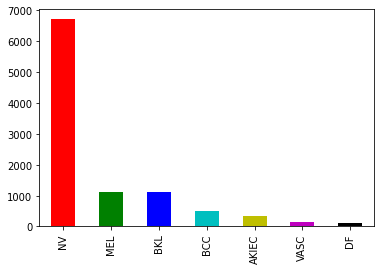

In [ ]:
detailedDataset['label'].value_counts().plot.bar(color=['r','g','b','c','y','m','k'])
print(detailedDataset['label'].value_counts())

# Divisão do dataset em meta-classes: benignos e malignos

Estratégia inicial para verificar o resultado do modelo com balancea,emto por subamostragem (downsampling) entre as duas meta-classes


In [ ]:
benignLesions = ['NV', 'BKL', 'DF', 'VASC']
malignLesions = ['MEL', 'BCC', 'AKIEC']
benignCode = 'Benigno'
malignCode = 'Maligno'

simplifiedDataset = detailedDataset.copy()

def classifyLesions(row):
  if row['label'] in benignLesions:
    return benignCode
  return malignCode

simplifiedDataset['type'] = simplifiedDataset.apply (lambda row: classifyLesions(row), axis=1)
simplifiedDataset = simplifiedDataset.drop('label', axis=1)
simplifiedDataset.head()

,image,type
0,ISIC_0024306,Benigno
1,ISIC_0024307,Benigno
2,ISIC_0024308,Benigno
3,ISIC_0024309,Benigno
4,ISIC_0024310,Maligno


# Aplicação de LabelEncoder(type)

Etapa executada antes da divisão de conjuntos para evitar custo computacional ao ter que verificar se os dois conjuntos estão se refereindo a meta classe da mesma forma.

Transformação de:
> Benigno->0

> Maligno-> 1

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
df = simplifiedDataset;
print(df)

              image     type
0      ISIC_0024306  Benigno
1      ISIC_0024307  Benigno
2      ISIC_0024308  Benigno
3      ISIC_0024309  Benigno
4      ISIC_0024310  Maligno
...             ...      ...
10010  ISIC_0034316  Maligno
10011  ISIC_0034317  Maligno
10012  ISIC_0034318  Benigno
10013  ISIC_0034319  Benigno
10014  ISIC_0034320  Benigno

[10015 rows x 2 columns]


In [ ]:
le = preprocessing.LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['type'].head()

0    0
1    0
2    0
3    0
4    1
Name: type, dtype: int64

# Obter as imagens do dataset

In [ ]:
PATH_PROCESSED_CONST = 'root/images/reshape-150_200/'

all_files = glob.glob(os.path.join(PATH_PROCESSED_CONST, "*.jpg"))
print(all_files[1])

root/images/reshape-150_200/ISIC_0031741.jpg


Aplicar greyscale e reshape nas imagens

In [ ]:
X = []
y = []
for img_name, img_type in zip(df['image'], df['type']):
  img = cv2.imread(PATH_PROCESSED_CONST + str(img_name)+'.jpg')
  img = np.asarray(img).astype(np.float32)#('float32')
  if not (np.isnan(img).any()):
    #img = tf.convert_to_tensor(img, dtype=tf.float32)
    X.append(img)
    y.append(img_type)

0    3804
1    1942
dtype: int64


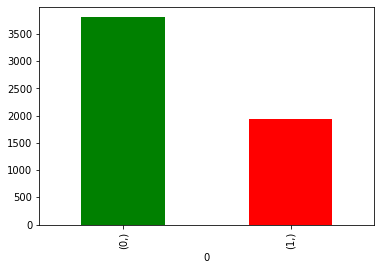

In [ ]:
# visualização grau de desbalanceamento
pd.DataFrame(y).value_counts().plot.bar(color=['g','r'])
print(pd.DataFrame(y).value_counts())

dataset is highly out of balance limit maximum samples per class to 1942 (balanceamento por baixo) samples to help balance it

# Balanceamento

A importância do balanceamento está na etapa de treinamento, entretando ele é realizado com a base inteira antes do treino e teste para não enviesar conjuntos de dados.

Ao optar por fazer o resample antes do split, faz com que o conjunto seja mais próximo de uma base de dados balanceada normal já que foi optado pelo downsampling. 

Foi escolhido fazer o resample de todo o conjunto de dados antes do split para evitar ter que averiguar se a distribuição do conjunto de treinamento se manteve a mesma do dataset para não enviesar o modelo com a reamostragem erroneamente.

Dado que o balanceamento será realizado antes do split, os dados de teste 

Importante deixar cada classe com a quantidade de imagens mais parecida possível.

Nessa abordagem inicial mais simples, queremos somente dividir o data set em duas classes e deixar a mesma quantidade de imagens para cada classe.


In [ ]:
img_shape = X[0].shape
img_shape 

(150, 200, 3)

In [ ]:
full_dataset = pd.DataFrame( {'X': X,'y': y})

size= 1942 # set number of samples for each class
samples = []

group= full_dataset.groupby('y')
for label in full_dataset['y'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['y'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 

balanced_df = pd.concat(samples, axis=0).reset_index(drop=True)

print(len(balanced_df))
print('final number of classes: ', len(balanced_df['y'].unique()))       
print(balanced_df['y'].value_counts())  

3884
final number of classes:  2
0    1942
1    1942
Name: y, dtype: int64


In [ ]:
X = np.array(balanced_df['X'])
y = np.array(balanced_df['y'])
#dataset = tf.data.Dataset.from_tensor_slices((balanced_df['X'],balanced_df['y']))
#balanced_df['X'].head()

In [ ]:
X[0].shape

(150, 200, 3)

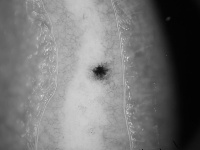

In [ ]:
cv2_imshow(X[0])

0    1942
1    1942
Name: y, dtype: int64


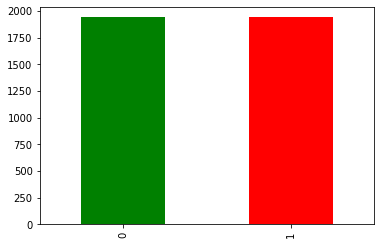

In [ ]:
balanced_df['y'].value_counts().plot.bar(color=['g','r'])
print(balanced_df['y'].value_counts())

# Train Test Split

Essa divisão do dataset está sendo feita após a etapa de balanceamento para prevenir bias (viéses) no treinamento que venham a resultar em um modelo com tendêncidas não generalizadas.
O objetivo do modelo é ser o mais geral possível

- Teste será feito com 20% do dataset já balanceado
- Treinamento será feito com 80% do dataset já balanceado

In [ ]:
test_size = .15 # set this to the percent of the data you want to use for validation
train_size = .85 # set this to the percentof the data you want to use for training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, train_size = train_size, random_state=42, shuffle=True)

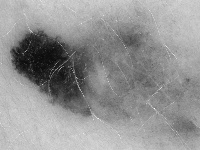

In [ ]:
cv2_imshow(X_train[0])

# Criar modelo

**goal**: transfer the learning of a ResNet-50 trained with Imagenet to a model that identify images from HAM10000 dataset.

- Construir uma rede neural CNN (tipo de modelo deep learning) levando em conta a dimensão das imagens com resize

- Utilização de CNN através da rede ResNet-50

**Convolutional Neural Network (CNN):** arquitetura de rede
- Arquitetura de rede neural com presença de camadas convolucionais, responsáveis por identificar padrões do dado de entrada, funcionando como um extrator de características inteligentes.
- Por ser uma arquitetura taxada como pesada, é comum a utilização de TL - utilização de um modelo base que é adaptado para a nova tarefa em questão, congelando os pesos de algumas camadas do modelo, necessitando o treinamento de apenas uma parcela das camadas do modelo final, reduzindo o custo computacional do modelo.

**Transfer Learning (TL):** metodologia de aprendizado
- Adapta um modelo base previamente treinado como forma de reduzir o processo de treinamento do modelo proposto
- use a model that has been trained on large scale data for our problem.
- Commonly used Transfer Learning Models: Inception, Xception, VGG Family, ResNet

**Deep Residual Networks (ResNet, ResNet50):** modelo específico de CNN
- specific type of convolutional neural network (CNN)
- is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer)
- Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.
- ResNet has supervised learning

https://www.tensorflow.org/tutorials/images/cnn

https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/

https://keras.io/api/applications/resnet/

Based on article: https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673


In [ ]:
resized_height = 150 # image height
resized_width = 200   # image width
resized_channels = 3  # number of color channels, RGB

In [ ]:
# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(resized_height, resized_width, resized_channels),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(resized_height, resized_width, resized_channels))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set Flatten Layer
x= tf.keras.layers.Flatten()(x)

# Set Dense Layers
x = tf.keras.layers.Dense(32, activation='relu',
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.001),
                          name='dense')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                           

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_train = np.array([np.array(val) for val in X_train])
X_test = np.array([np.array(val) for val in X_test])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.10) #75% dados de treinamento, 10% de validação 15% de teste

Epoch 1/20
93/93 [==============================] - 13s 101ms/step - loss: 0.6485 - accuracy: 0.6993 - val_loss: 0.5593 - val_accuracy: 0.7734
Epoch 2/20
93/93 [==============================] - 7s 77ms/step - loss: 0.5598 - accuracy: 0.7485 - val_loss: 0.5089 - val_accuracy: 0.7704
Epoch 3/20
93/93 [==============================] - 8s 83ms/step - loss: 0.5208 - accuracy: 0.7751 - val_loss: 0.5063 - val_accuracy: 0.7674
Epoch 4/20
93/93 [==============================] - 7s 76ms/step - loss: 0.5001 - accuracy: 0.7825 - val_loss: 0.4997 - val_accuracy: 0.7704
Epoch 5/20
93/93 [==============================] - 7s 77ms/step - loss: 0.4993 - accuracy: 0.7845 - val_loss: 0.4857 - val_accuracy: 0.8066
Epoch 6/20
93/93 [==============================] - 7s 77ms/step - loss: 0.4708 - accuracy: 0.7980 - val_loss: 0.4670 - val_accuracy: 0.8187
Epoch 7/20
93/93 [==============================] - 8s 86ms/step - loss: 0.4657 - accuracy: 0.8077 - val_loss: 0.4626 - val_accuracy: 0.7946
Epoch 8/20


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

19/19 - 1s - loss: 0.5627 - accuracy: 0.7530 - 1s/epoch - 67ms/step
0.7530016899108887


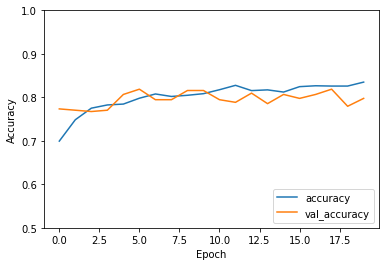

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

19/19 [==============================] - 2s 63ms/step


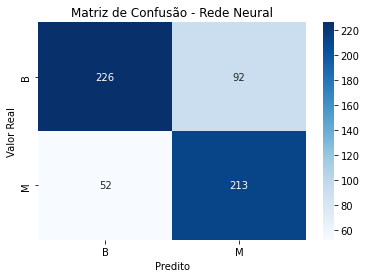

In [ ]:
y_pred = model.predict(X_test)
y_p = np.where(y_pred > 0.5, 1, 0)
y_true = y_test
cm = confusion_matrix(y_true, y_p)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Rede Neural')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

In [ ]:
target_names = ['benigno', 'maligno'] # 0 = benigno, 1 = maligno
print(classification_report(y_true, y_p, target_names=target_names))

              precision    recall  f1-score   support

     benigno       0.81      0.71      0.76       318
     maligno       0.70      0.80      0.75       265

    accuracy                           0.75       583
   macro avg       0.76      0.76      0.75       583
weighted avg       0.76      0.75      0.75       583



In [ ]:
feature_vectors_model = Model(model.input, model.get_layer('dense').output)
train_features = feature_vectors_model.predict(X_train)
test_features = feature_vectors_model.predict(X_test)

19/19 [==============================] - 1s 60ms/step


Use /tmp/tmp1jv2qkef as temporary training directory
Reading training dataset...


Training dataset read in 0:00:02.555331. Found 3301 examples.
Training model...
Model trained in 0:00:02.331391
Compiling model...
Model compiled.


19/19 [==============================] - 0s 3ms/step


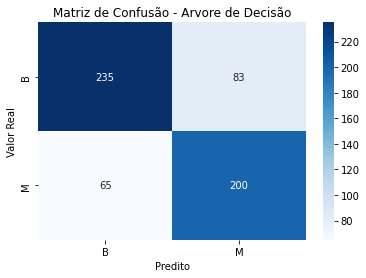

              precision    recall  f1-score   support

           b       0.78      0.74      0.76       318
           m       0.71      0.75      0.73       265

    accuracy                           0.75       583
   macro avg       0.75      0.75      0.75       583
weighted avg       0.75      0.75      0.75       583



In [ ]:
# Decision Forest:
import tensorflow_decision_forests as tfdf
model_tree = tfdf.keras.RandomForestModel()
model_tree.fit(train_features,y_train)

yp_t = model_tree.predict(test_features)
yp_t = np.where(yp_t > 0.5, 1, 0)

y_true = y_test
cm = confusion_matrix(y_true, yp_t)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Arvore de Decisão')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

print(classification_report(y_test, yp_t, target_names=['b','m']))

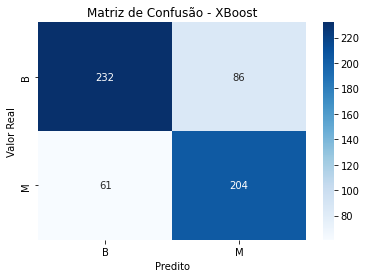

              precision    recall  f1-score   support

           b       0.79      0.73      0.76       318
           m       0.70      0.77      0.74       265

    accuracy                           0.75       583
   macro avg       0.75      0.75      0.75       583
weighted avg       0.75      0.75      0.75       583



In [ ]:
#XGBOOST

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(train_features, y_train)

# Predict
yp_x = xgb_cl.predict(test_features)
yp_x = np.where(yp_x > 0.5, 1, 0)

y_true = y_test
cm = confusion_matrix(y_true, yp_x)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - XBoost')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

print(classification_report(y_test, yp_x, target_names=['b','m']))

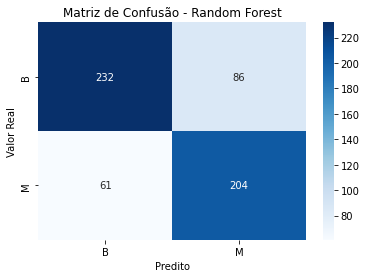

              precision    recall  f1-score   support

           b       0.79      0.73      0.76       318
           m       0.70      0.77      0.74       265

    accuracy                           0.75       583
   macro avg       0.75      0.75      0.75       583
weighted avg       0.75      0.75      0.75       583



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=15, random_state=0)
rf.fit(train_features, y_train)

yp_rf = rf.predict(test_features)
yp_rf = np.where(yp_x > 0.5, 1, 0)

y_true = y_test
cm = confusion_matrix(y_true, yp_rf)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Random Forest')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

print(classification_report(y_test, yp_rf, target_names=['b','m']))

In [ ]:
preds = np.array([np.array(y_p).reshape(583,),
                  np.array(yp_t).reshape(583,) , 
                  np.array(list(yp_x)).reshape(583,),
                  np.array(list(yp_rf)).reshape(583,)
                  ])

m = stats.mode(preds)[0][0]

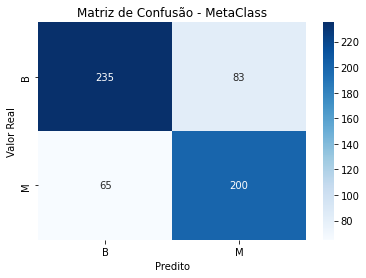

              precision    recall  f1-score   support

           b       0.78      0.74      0.76       318
           m       0.71      0.75      0.73       265

    accuracy                           0.75       583
   macro avg       0.75      0.75      0.75       583
weighted avg       0.75      0.75      0.75       583



In [ ]:
# MetaClass

from scipy import stats
y_m = m
#ym_t = np.where(y_m > 0.5, 1, 0)

y_true = y_test
cm = confusion_matrix(y_true, y_m)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - MetaClass')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

print(classification_report(y_test, y_m, target_names=['b','m']))

# Conclusão sobre os resultados:

